In [1]:
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Transform for MNIST (resize to 224x224 and 3 channels for pretrained models)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Load only the original MNIST training dataset (60,000 samples)
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Define split sizes (70%, 15%, 15%)
total_size = len(mnist_train)  # 60000
train_size = int(0.7 * total_size)  # 42000
val_size = int(0.15 * total_size)   # 9000
test_size = total_size - train_size - val_size  # 9000

# Split into train, validation, and test sets
torch.manual_seed(42)  # ensures reproducibility
train_dataset, val_dataset, test_dataset = random_split(mnist_train, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print sizes to verify
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]

Training samples: 42000
Validation samples: 9000
Testing samples: 9000


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 84.0MB/s]


In [7]:
# ResNet modification
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

resnet.fc = nn.Sequential(
    nn.Linear(512, 512),        # input from ResNet backbone
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)          # output for 10 MNIST classes
)


# VGG modification
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

for param in vgg.features.parameters():
    param.requires_grad = False

vgg.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 10)
)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, epochs=3, lr=0.001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0.0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

    return model

def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    preds, targets = [], []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    test_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average='weighted')
    recall = recall_score(targets, preds, average='weighted')
    f1 = f1_score(targets, preds, average='weighted')

    print(f"\n📊 Performance Metrics for {model_name}:")
    print(f"Test Loss     : {test_loss:.4f}")
    print(f"Accuracy      : {accuracy*100:.2f}%")
    print(f"Precision     : {precision:.4f}")
    print(f"Recall        : {recall:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    print("\nDetailed Classification Report:")
    print(classification_report(targets, preds, digits=4))

    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return accuracy, precision, recall, f1, test_loss



In [9]:
resnet_trained = train_model(resnet, train_loader, val_loader, epochs=3)
vgg_trained = train_model(vgg, train_loader, val_loader, epochs=3)


Epoch [1/3] | Train Loss: 0.1204 | Val Loss: 0.0640
Epoch [2/3] | Train Loss: 0.0527 | Val Loss: 0.0379
Epoch [3/3] | Train Loss: 0.0423 | Val Loss: 0.0295
Epoch [1/3] | Train Loss: 0.0935 | Val Loss: 0.0416
Epoch [2/3] | Train Loss: 0.0386 | Val Loss: 0.0322
Epoch [3/3] | Train Loss: 0.0317 | Val Loss: 0.0371



📊 Performance Metrics for ResNet18 Fine-Tuned:
Test Loss     : 0.0307
Accuracy      : 99.23%
Precision     : 0.9924
Recall        : 0.9923
F1 Score      : 0.9923

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9932    0.9944    0.9938       886
           1     0.9951    0.9912    0.9931      1018
           2     0.9833    0.9888    0.9860       891
           3     0.9957    0.9978    0.9967       922
           4     0.9865    0.9955    0.9910       884
           5     0.9961    0.9910    0.9935       775
           6     0.9954    0.9921    0.9938       882
           7     0.9858    0.9949    0.9903       975
           8     0.9977    0.9921    0.9949       882
           9     0.9954    0.9853    0.9903       885

    accuracy                         0.9923      9000
   macro avg     0.9924    0.9923    0.9923      9000
weighted avg     0.9924    0.9923    0.9923      9000



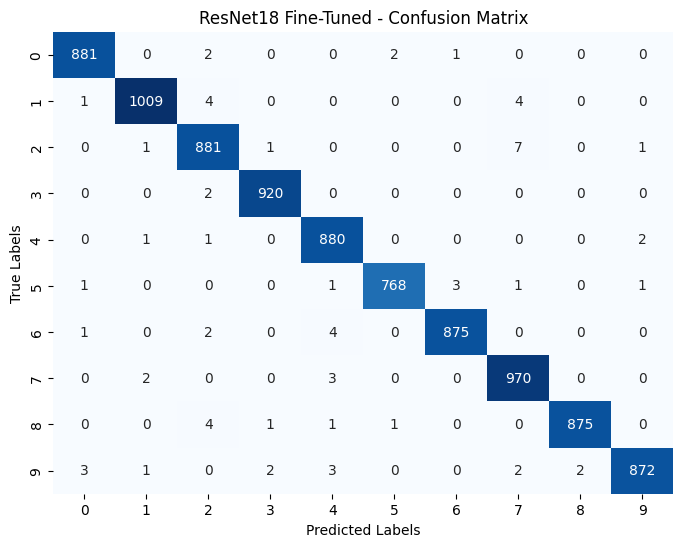


📊 Performance Metrics for VGG16 Fine-Tuned:
Test Loss     : 0.0370
Accuracy      : 98.98%
Precision     : 0.9899
Recall        : 0.9898
F1 Score      : 0.9898

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9877    0.9977    0.9927       886
           1     0.9951    0.9902    0.9926      1018
           2     0.9855    0.9921    0.9888       891
           3     0.9924    0.9924    0.9924       922
           4     0.9778    0.9955    0.9865       884
           5     0.9961    0.9794    0.9876       775
           6     0.9977    0.9921    0.9949       882
           7     0.9778    0.9959    0.9868       975
           8     0.9898    0.9909    0.9904       882
           9     1.0000    0.9695    0.9845       885

    accuracy                         0.9898      9000
   macro avg     0.9900    0.9896    0.9897      9000
weighted avg     0.9899    0.9898    0.9898      9000



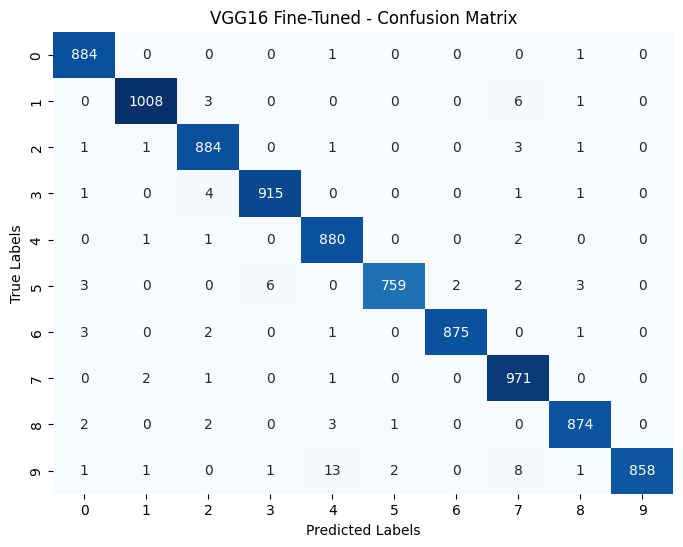

In [10]:
resnet_metrics = evaluate_model(resnet_trained, test_loader, model_name="ResNet18 Fine-Tuned")
vgg_metrics = evaluate_model(vgg_trained, test_loader, model_name="VGG16 Fine-Tuned")
